In [1]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import sys

from collections import defaultdict, OrderedDict
matplotlib.style.use('ggplot')

import mytaxi

In [2]:
env = gym.make('Taxi-v3').unwrapped
numS = env.observation_space.n
numA = env.action_space.n
print("#state:{}, #action{}".format(numS, numA))

#state:501, #action6


In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1, epsilon=0.1, alpha=1.0, runs=10):
    runs = 10
    rew_alloc = []
    for run in range(runs):
        np.random.seed(run)
        env.seed(run)
        returns_sum = defaultdict(float)
        returns_count = defaultdict(float)

        # The final action-value function.
        # A nested dictionary that maps state -> (action -> action-value).
        Q = defaultdict(lambda: np.zeros(env.action_space.n))

        policy = make_epsilon_greedy_policy(Q, epsilon, numA)
        rew_list = np.zeros(int(num_episodes/50))
        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if i_episode % 1000 == 0:
                print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
                sys.stdout.flush()

            # Generate an episode.
            # An episode is an array of (state, action, reward) tuples
            episode = []
            state = env.reset()
            done = False
    #         while not done:
            for t in range(1000):
                probs = policy(state)
                action = np.random.choice(np.arange(len(probs)), p=probs)
                next_state, reward, done, _ = env.step(action)
                episode.append((state, action, reward))
                if i_episode % 50 == 0:
                    idx = int(i_episode / 50) 
                    rew_list[idx] += reward
                if done:
                    break
                state = next_state

            # Find all (state, action) pairs we've visited in this episode
            sa_in_episode = set([(x[0], x[1]) for x in episode])
            for state, action in sa_in_episode:
                sa_pair = (state, action)
                # Find the first occurance of the (state, action) pair in the episode
                first_occurence_idx = next(i for i,x in enumerate(episode)
                                           if x[0] == state and x[1] == action)
                # Sum up all rewards since the first occurance
                G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
                # Calculate average return for this state over all sampled episodes
    #             returns_sum[sa_pair] += G
                returns_sum[sa_pair] = alpha * returns_sum[sa_pair] + G
                returns_count[sa_pair] += 1.0
                # The policy is improved implicitly by changing the Q dictionary
                Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        rew_alloc.append(rew_list)
    rew_list = np.mean(np.array(rew_alloc),axis=0)
    fig = plt.figure()
    plt.plot(rew_list)
    plt.savefig('mc_control-interim.eps')
    plt.close(fig)
        
    return Q, policy

In [5]:
def plot_value_function(V, baseline, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    V_ordered = OrderedDict(sorted(V.items()))
    
    print('\n')
    print(len(V.keys()))
    
    v_s = np.zeros(len(V.keys()))
    idx = 0
    for key, val in V_ordered.items():
        v_s[idx] = val
        idx +=1

    # print(np.sort(np.asarray(V.keys())))

#     plt.plot(np.asarray(v_s), marker='o',linewidth=2)
    plt.plot(v_s,marker='o',linestyle='None',label='mc')
    plt.plot(baseline,marker='x',linestyle='None',label='base')
    plt.legend(["MC", "Baseline"])
    plt.title(title)
    plt.xlabel("State", fontsize=20)
    plt.savefig("MC_control.png")

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1, runs=10)
print("Q:{}".format(type(Q)))
print(Q.keys())

Episode 9000/10000.Q:<class 'collections.defaultdict'>
dict_keys([221, 321, 421, 441, 341, 492, 392, 472, 476, 376, 496, 396, 372, 491, 391, 471, 371, 160, 260, 360, 460, 480, 380, 386, 486, 466, 286, 366, 180, 280, 60, 40, 140, 240, 340, 440, 420, 320, 186, 86, 266, 98, 198, 298, 398, 498, 478, 474, 494, 193, 293, 393, 493, 473, 477, 497, 397, 377, 373, 269, 369, 469, 489, 389, 64, 164, 264, 284, 384, 484, 464, 364, 100, 200, 300, 400, 110, 210, 310, 410, 418, 220, 80, 485, 465, 365, 385, 444, 424, 324, 344, 490, 390, 470, 370, 287, 267, 367, 467, 487, 387, 192, 292, 272, 252, 352, 452, 432, 332, 406, 306, 434, 454, 354, 334, 126, 226, 326, 426, 446, 346, 71, 171, 271, 291, 191, 251, 351, 451, 431, 331, 21, 121, 101, 201, 301, 401, 67, 167, 187, 147, 247, 347, 447, 427, 327, 169, 149, 249, 349, 449, 429, 329, 133, 233, 333, 433, 453, 353, 166, 146, 246, 26, 6, 106, 206, 72, 172, 92, 152, 52, 132, 232, 212, 312, 412, 46, 66, 78, 178, 278, 378, 374, 394, 294, 274, 407, 307, 142, 242, 34



500


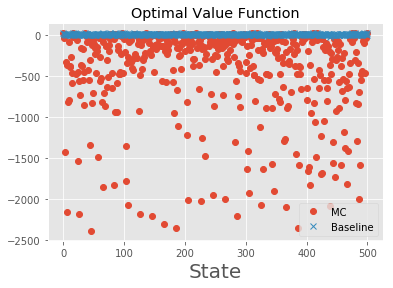

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
baseline = np.load('baseline.npy')
plot_value_function(V, baseline, title="Optimal Value Function")
# plot_Q_table()
with open('qtable_mc','w') as fp:
    fp.write(str(Q))